# Instalacion e importacion de librerias.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchvision numpy pandas torch matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

#Leer el dataset

Se lee el dataset, y se estandariza un formato de imagen, para finalmente pasarlo a una matriz representativa de la imagen.

In [ ]:
transformer = torchvision.transforms.Compose(
    [  # Applying Augmentation
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(30),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)
dataset = ImageFolder("/content/drive/MyDrive/IA/DataSetT4/Iris", transform=transformer)


print(len(dataset), dataset[66], dataset[335], dataset[420])
#Las primeras 67 fotos tienen etiqueta 0 -> Setosa
#Luego, las fotos  [67-335] tienen etiqueta 1 -> Versicolour
#Finalmente las fotos [336-420] tienen etiqueta 2 -> Virginica


421 (tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..

# Detecccion Hardware

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()

#Separar los datos en entrenamiento, validacion y testing




In [ ]:
numDatos = len(dataset)
validation_size = int(numDatos*0.2)
training_size = numDatos - validation_size
train_ds, val_ds_main = random_split(dataset,[training_size, validation_size])
val_ds, test_ds  = random_split(val_ds_main,[int(validation_size/2), int(validation_size/2)])
print(len(train_ds), len(val_ds), len(test_ds))# 337, 42, 42 


337 42 42


In [ ]:
train_dl = DataLoader(train_ds, batch_size = 32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size = 32)
test_dl = DataLoader(test_ds, batch_size = 32)

print(len(train_dl), len(val_dl), len(test_dl))# 8, 3, 3

#Transformar los DataLoader a Tensor CUDA
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

11 2 2


#Definicion del modelo de la CNN a entrenar.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationModel(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        #print(len(images)) #32 Batch size
        #print(len(images[0]))#3 Chanel input
        #print(len(images[0][0]))# 224 #Valores X de la imagen
        #print(len(images[0][0][0]))# 224 Valores Y de la imagen
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #output 16 x (224/2) x 112

            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #output 64 x (112/2) x 56


            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=7, stride=2, padding=3),#  output:  [ 56-1+(2x3)-[(1)x (7-1)] / 2 ] + 1 = 28
            nn.ReLU(),


            nn.Flatten(), 
            nn.Linear(128*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 4))
        
    def forward(self, xb):
        return self.network(xb)
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# Entendiendo

In [ ]:
input = torch.randn(3, 2, 56, 56)
print("Batch size: ",len(input)) #Batch size
print("Channel size: ",len(input[0]))#3 Chanel input
print("ImagenX size: ",len(input[0][0]))# 224 #Valores X de la imagen
print("ImagenY size: ",len(input[0][0][0]))# 224 Valores Y de la imagen
conv = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=7, stride=2, padding=3)
a = conv(input)
print("-------Aplicando Convolucion nn.Conv2d(in_channels=2, out_channels=4, kernel_size=1, stride=1, padding=0) ----------")
print("Batch size: ",len(a)) #Batch size
print("Channel size: ",len(a[0]))#3 Chanel input
print("ImagenX size: ",len(a[0][0]))# 224 #Valores X de la imagen
print("ImagenY size: ",len(a[0][0][0]))# 224 Valores Y de la imagen


conv = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=1, stride=1, padding=2)
a = conv(a)
print("-------Aplicando Convolucion nn.Conv2d(in_channels=4, out_channels=8, kernel_size=1, stride=1, padding=2) ----------") # size = size x 2 Paddig, dado que hay 2 ejes
print("Batch size: ",len(a)) #Batch size
print("Channel size: ",len(a[0]))# Chanel input
print("ImagenX size: ",len(a[0][0]))# #Valores X de la imagen
print("ImagenY size: ",len(a[0][0][0]))# Valores Y de la imagen

maxPool = nn.MaxPool2d(2, 2);#
a=maxPool(a);
print("-------Aplicando  nn.MaxPool2d(2, 2) ----------") # Apox sup de Imagen size / KernelsizeMaxPool
print("Batch size: ",len(a)) # Batch size
print("Channel size: ",len(a[0]))# Chanel input
print("ImagenX size: ",len(a[0][0]))# Valores X de la imagen
print("ImagenY size: ",len(a[0][0][0]))# Valores Y de la imagen

m=nn.Flatten();
a=m(a)
print("-------Aplicando  nn.Flatten(a) ----------") # Apox sup de Imagen size / KernelsizeMaxPool
print("Flaten size: ", a.size())


############### Resumen ##########

"""
1. Cada tensor, tiene un Batch, canal de size y las dimensiones de la imagen
2. Conv2d, pondera la longitud del canal
3. MaxPool, reduce segun el tamaño del kernel el tamaño de la imagen.

"""





Batch size:  3
Channel size:  2
ImagenX size:  56
ImagenY size:  56
-------Aplicando Convolucion nn.Conv2d(in_channels=2, out_channels=4, kernel_size=1, stride=1, padding=0) ----------
Batch size:  3
Channel size:  4
ImagenX size:  28
ImagenY size:  28
-------Aplicando Convolucion nn.Conv2d(in_channels=4, out_channels=8, kernel_size=1, stride=1, padding=2) ----------
Batch size:  3
Channel size:  8
ImagenX size:  32
ImagenY size:  32
-------Aplicando  nn.MaxPool2d(2, 2) ----------
Batch size:  3
Channel size:  8
ImagenX size:  16
ImagenY size:  16
-------Aplicando  nn.Flatten(a) ----------
Flaten size:  torch.Size([3, 2048])


'\n1. Cada tensor, tiene un Batch, canal de size y las dimensiones de la imagen\n2. Conv2d, pondera la longitud del canal\n3. MaxPool, reduce segun el tamaño del kernel el tamaño de la imagen.\n\n'

#Entrenar el modelo con distintos periodos de entrenamiento.

Probar y entrenar el modelo con hasta una determinada cantida de periodos para evidenciar a partir de su acierto cual es el valor indicado para esta. Ademas de su funcion de optimicacion y precision.

In [ ]:
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.001

Iteramos aprendizajes con distintos periodos de entrenamiento, pero misma funcion de optimizacion y precision. 

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


model = to_device(ImageClassificationModel(), device)
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.6525, val_loss: 0.9780, val_acc: 0.7437
Epoch [1], train_loss: 1.0678, val_loss: 0.7805, val_acc: 0.7437
Epoch [2], train_loss: 0.9542, val_loss: 0.8938, val_acc: 0.7437
Epoch [3], train_loss: 0.9829, val_loss: 0.7600, val_acc: 0.7437
Epoch [4], train_loss: 0.9537, val_loss: 0.7697, val_acc: 0.7437
Epoch [5], train_loss: 0.9409, val_loss: 0.7450, val_acc: 0.7437
Epoch [6], train_loss: 0.9350, val_loss: 0.7808, val_acc: 0.7437
Epoch [7], train_loss: 0.9274, val_loss: 0.7244, val_acc: 0.7437
Epoch [8], train_loss: 0.9089, val_loss: 0.7326, val_acc: 0.7437
Epoch [9], train_loss: 0.9144, val_loss: 0.6905, val_acc: 0.7437
Epoch [10], train_loss: 0.9551, val_loss: 0.6965, val_acc: 0.7437
Epoch [11], train_loss: 0.9142, val_loss: 0.7847, val_acc: 0.7437
Epoch [12], train_loss: 0.9000, val_loss: 0.7209, val_acc: 0.7437
Epoch [13], train_loss: 0.8744, val_loss: 0.7627, val_acc: 0.7281
Epoch [14], train_loss: 0.8626, val_loss: 0.8347, val_acc: 0.6781
Epoch [15], train_lo

#Resultados

Graficamos las iteraciones de distintos periodos de entrenamiento y sus porcentaje de acierto

Maximum val_acc: 0.7437499761581421  In Epoch :  0
Minimum val_acc: 0.528124988079071  In Epoch :  36


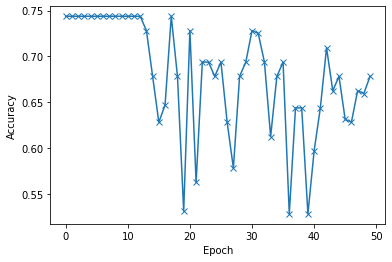

In [ ]:
max_value = None
max_Epoch = None
min_value = None
min_Epoch = None
countEpoch = 0

for x in history :
    if (max_value is None or x['val_acc'] > max_value):
        max_value = x['val_acc']
        max_Epoch = countEpoch
    if (min_value is None or x['val_acc'] < min_value):
        min_value = x['val_acc']
        min_Epoch = countEpoch
    countEpoch +=1

print('Maximum val_acc:', max_value, " In Epoch : ",max_Epoch )
print('Minimum val_acc:', min_value, " In Epoch : ",min_Epoch )


def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
plot_accuracies(history)

#Predi


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationModel(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
      
        out = self(images)                  # Generate predictions
        print("Parametros de la imagen: ", out)
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #output 16 x (224/2) x 112

            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #output 64 x (112/2) x 56


            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=7, stride=2, padding=3),#  output:  [ 56-1+(2x3)-[(1)x (7-1)] / 2 ] + 1 = 28
            nn.ReLU(),


            nn.Flatten(), 
            nn.Linear(128*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 4))
        
    def forward(self, xb):
        return self.network(xb)
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [ ]:
num_epochs =20
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


model = to_device(ImageClassificationModel(), device)
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Se truncaron las últimas líneas 5000 del resultado de transmisión.
        [ 0.5528,  1.6628,  0.5876, -4.8442],
        [ 0.8005,  2.4488,  0.8665, -7.1213],
        [ 0.7086,  2.1543,  0.7606, -6.2670],
        [ 0.8943,  2.7043,  0.9566, -7.8790],
        [ 0.7938,  2.4183,  0.8546, -7.0350],
        [ 0.9643,  2.9166,  1.0285, -8.4932],
        [ 0.8453,  2.5716,  0.9089, -7.4830],
        [ 0.8150,  2.4796,  0.8760, -7.2147],
        [ 0.6790,  2.0639,  0.7311, -6.0056],
        [ 0.7580,  2.3090,  0.8174, -6.7196],
        [ 0.7432,  2.2650,  0.8004, -6.5879],
        [ 0.9120,  2.7677,  0.9782, -8.0575],
        [ 0.7895,  2.4062,  0.8515, -7.0007],
        [ 1.1271,  3.4334,  1.2144, -9.9926],
        [ 0.6891,  2.0933,  0.7394, -6.0903],
        [ 0.8166,  2.4812,  0.8759, -7.2197],
        [ 0.6159,  1.8570,  0.6533, -5.4047],
        [ 0.8321,  2.5333,  0.8951, -7.3707],
        [ 0.6828,  2.0868,  0.7393, -6.0693],
        [ 0.7416,  2.2522,  0.7980, -6.5576],
        [ 0.8

Maximum val_acc: 0.7593749761581421  In Epoch :  12
Minimum val_acc: 0.628125011920929  In Epoch :  9


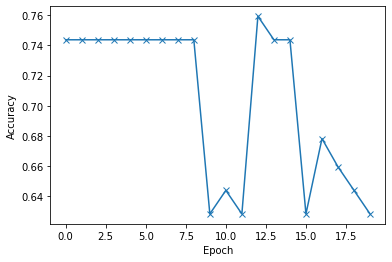

In [ ]:
max_value = None
max_Epoch = None
min_value = None
min_Epoch = None
countEpoch = 0

for x in history :
    if (max_value is None or x['val_acc'] > max_value):
        max_value = x['val_acc']
        max_Epoch = countEpoch
    if (min_value is None or x['val_acc'] < min_value):
        min_value = x['val_acc']
        min_Epoch = countEpoch
    countEpoch +=1

print('Maximum val_acc:', max_value, " In Epoch : ",max_Epoch )
print('Minimum val_acc:', min_value, " In Epoch : ",min_Epoch )


def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
plot_accuracies(history)